In [1]:
conda install lightgbm

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import datetime
import os

from data_processing import Data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.svm import SVR

In [4]:
available_data = Data('train').data

In [20]:
available_data

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500
...,...,...,...,...,...,...,...,...,...,...
37132,37132,3.3438,50.0,4.936508,1.079365,1775.0,3.022222,34.19,-118.36,1.856
37133,37133,3.7308,26.0,5.087533,0.966019,1006.0,4.316901,37.32,-121.86,1.588
37134,37134,4.1716,52.0,4.678862,1.101485,1156.0,1.431734,37.75,-122.44,3.387
37135,37135,2.7143,16.0,5.710074,1.068376,584.0,2.803659,38.40,-120.98,1.592


# LightGBM Trial

In [21]:
available_data.isnull().sum()

id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [5]:
class Data:
    def __init__(self, data_type: str = 'train'):
        self.data_type = data_type
        self.data = pd.read_csv('train.csv', index_col=0) if data_type == 'train' else pd.read_csv('test.csv',
                                                                                                   index_col=0)

    @staticmethod
    def get_train_test_split(test_size: float = 0.3, random_state: int = 42):
        X = pd.read_csv('train.csv', index_col=0).drop('MedHouseVal', axis=1)
        y = pd.read_csv('train.csv', index_col=0)['MedHouseVal']
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return x_train, x_test, y_train, y_test

In [6]:
data = Data('train')
x_train, x_test, y_train, y_test = data.get_train_test_split()

In [55]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 30,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('开始训练...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=30,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('保存模型...')
gbm.save_model('lgb_model.txt')

print('开始预测...')
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

print('预估结果的rmse为:')
print(mean_squared_error(y_test, y_pred) ** 0.5)

开始训练...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 1.18907	valid_0's auc: 1
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 1.06805	valid_0's auc: 1
[3]	valid_0's l2: 0.954586	valid_0's auc: 1
[4]	valid_0's l2: 0.872976	valid_0's auc: 1
[5]	valid_0's l2: 0.794956	valid_0's auc: 1
[6]	valid_0's l2: 0.729541	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's l2: 1.18907	valid_0's auc: 1
保存模型...
开始预测...
预估结果的rmse为:
1.0904448638144022


# XGBoost

In [60]:
!pip install xgboost

     |████████████████████████████████| 1.8 MB 27.6 MB/s eta 0:00:01


In [63]:
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [114]:
data = Data('train')
x_train, x_test, y_train, y_test = data.get_train_test_split()

In [115]:
n_estimator = list(range(100, 1000, 50))

for estimator in n_estimator:
    print(f'estimator is: {estimator}')
    params = {
        'n_estimators': estimator,
        'max_depth': 5,
        'learning_rate': 0.08,
        'reg_alpha': 0.1,
        'reg_lambda': 0.9,
        'objective': 'reg:squarederror',
        'verbosity': 0
    }

    model = xgb.XGBRegressor(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    print(f'rsme is: ', mean_squared_error(y_pred, y_test) ** 0.5)

estimator is: 100
rsme is:  0.5951608804983991
estimator is: 150
rsme is:  0.5897505695690545
estimator is: 200
rsme is:  0.5876890418377806
estimator is: 250
rsme is:  0.5862338329868256
estimator is: 300
rsme is:  0.5851450231344112
estimator is: 350
rsme is:  0.5846718656197837
estimator is: 400
rsme is:  0.5843587534983223
estimator is: 450
rsme is:  0.5839769335203581
estimator is: 500
rsme is:  0.5835009869571068
estimator is: 550
rsme is:  0.5827557697126526
estimator is: 600
rsme is:  0.582702082149625
estimator is: 650
rsme is:  0.5826752489042742
estimator is: 700
rsme is:  0.5822929123515511
estimator is: 750
rsme is:  0.5822654778840444
estimator is: 800
rsme is:  0.5826154623859073
estimator is: 850
rsme is:  0.5826535407882079
estimator is: 900
rsme is:  0.5829032453511076
estimator is: 950
rsme is:  0.5830785941568687


In [116]:
# So maybe we should use 750
params = {
    'n_estimators': 750,
    'max_depth': 5,
    'learning_rate': 0.08,
    'reg_alpha': 0.1,
    'reg_lambda': 0.9,
    'objective': 'reg:squarederror',
    'verbosity': 0
}

model = xgb.XGBRegressor(**params)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(f'rsme is: ', mean_squared_error(y_pred, y_test) ** 0.5)

rsme is:  0.5822654778840444


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

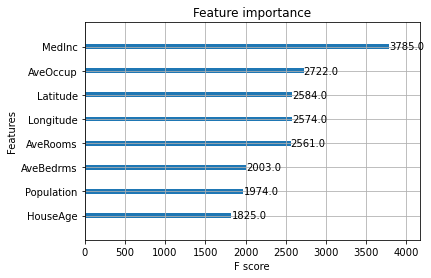

In [117]:
xgb.plot_importance(model)

In [118]:
x_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
id,,,,,,,,
31089,5.0855,17.0,6.190805,1.105747,1538.0,3.373563,38.02,-121.36
28863,3.3636,5.0,4.239899,1.020202,3278.0,2.066007,33.68,-117.53
20379,5.0417,29.0,6.602317,1.023529,1119.0,2.705479,33.84,-117.95
3942,4.1364,22.0,5.448584,0.986717,1750.0,3.020478,38.47,-121.77
26360,1.6031,39.0,4.742204,1.075092,1168.0,3.250000,36.75,-119.80


In [119]:
prediction_data = Data('test').data
prediction_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
id,,,,,,,,
37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29
37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81
37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34
37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29


In [120]:
y_pred = model.predict(prediction_data)

# make to correct format
columns_name = ['MedHouseVal']
df_for_submission = pd.DataFrame(data=y_pred, index=prediction_data.index, columns=columns_name)
df_for_submission.to_csv(os.path.join(os.getcwd(), 'for_submission', 'xgb_result.csv'))

In [122]:
189/289

0.6539792387543253

# SVM-SVR Trial

In [124]:
data = Data('train')
x_train, x_test, y_train, y_test = data.get_train_test_split()

In [131]:
params = {
    'C': 1.0,
    'kernel': 'rbf',
    'gamma': 'auto',
    'cache_size': 100,
    'degree': 3
}

model_svm = SVR(**params)
model_svm.fit(x_train, y_train)

y_pred = model_svm.predict(x_test)

print(f'rsme is: ', mean_squared_error(y_pred, y_test) ** 0.5)

rsme is:  1.0642501029165188


In [126]:
x_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
id,,,,,,,,
17647,4.9643,33.0,5.649425,1.011494,1390.0,2.826271,34.04,-118.48
11010,4.7946,13.0,7.337500,1.031250,1888.0,2.690972,38.65,-121.36
35733,4.7094,13.0,6.527646,1.132189,1884.0,2.935860,33.83,-117.21
6552,5.8898,16.0,6.205937,1.024015,2318.0,3.291809,34.22,-118.88
17191,2.3456,11.0,3.371642,1.139326,729.0,2.539735,34.16,-118.37
...,...,...,...,...,...,...,...,...
16850,2.7797,35.0,4.539378,1.035316,1583.0,3.128959,37.35,-121.86
6265,3.0481,39.0,5.930000,1.171875,779.0,2.738750,35.34,-119.01
11284,3.6346,33.0,5.010462,1.021423,2099.0,2.263598,37.65,-122.43


# Basic Neural Network

In [134]:
!pip install torch

     |████████████████████████████████| 135.3 MB 327 kB/s eta 0:00:01     |███████████████████████████████▎| 132.4 MB 306 kB/s eta 0:00:10


In [7]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

In [1]:
data = Data('train')
x_train, x_test, y_train, y_test = data.get_train_test_split()

x_train = torch.tensor(x_train.values)
x_test = torch.tensor(x_test.values)
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

NameError: name 'Data' is not defined

In [ ]:
# x_train = torch.from_numpy(x_train.values).float().to('cpu')

In [137]:
seq_net = nn.Sequential(
    nn.Linear(9, 4),  # PyTorch 中的线性层，wx + b
    nn.ReLU(),
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
)

param = seq_net.parameters()
optim = torch.optim.SGD(param, 1.)

# 自定义RMSE，因为只有MSE
def RMSELoss(yhat, y):
    return torch.sqrt(torch.mean((yhat - y) ** 2))

criterion = RMSELoss

# 训练n次
for e in range(10000):
    out = seq_net(Variable(x_train))
    loss = criterion(out, Variable(y_train))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, RMSE loss: {}'.format(e + 1, loss.data[0]))

TypeError: Variable data has to be a tensor, but got DataFrame

In [ ]:
y_pred = seq_net(Variable(x_test))